# Imports

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data

In [ ]:
data = yf.download("AAPL",  start="2022-09-13", end="2025-09-13", auto_adjust=False)

[*********************100%***********************]  1 of 1 completed


# Cleaning Data

In [ ]:
data = data.sort_values(by="Date", ascending=True)
data = data.dropna()
data.fillna(method="ffill", inplace=True)

#Counting NaN values
sum = data.isnull().sum()
print("\n\033[1mMissing Values:\033[0m")
print(sum)


Missing Values:
Price      Ticker
Adj Close  AAPL      0
Close      AAPL      0
High       AAPL      0
Low        AAPL      0
Open       AAPL      0
Volume     AAPL      0
dtype: int64


/tmp/ipython-input-1344146867.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="ffill", inplace=True)


# Data Analysis

In [ ]:
print(f"Attributes: {data.columns}")
data.head()

Attributes: MultiIndex([('Adj Close', 'AAPL'),
            (    'Close', 'AAPL'),
            (     'High', 'AAPL'),
            (      'Low', 'AAPL'),
            (     'Open', 'AAPL'),
            (   'Volume', 'AAPL')],
           names=['Price', 'Ticker'])


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2022-09-13,151.449326,153.839996,160.539993,153.369995,159.899994,122656600
2022-09-14,152.896469,155.309998,157.100006,153.610001,154.789993,87965400
2022-09-15,150.002136,152.369995,155.240005,151.380005,154.649994,90481100
2022-09-16,148.358124,150.699997,151.350006,148.369995,151.210007,162278800
2022-09-19,152.079376,154.479996,154.559998,149.100006,149.309998,81474200


In [ ]:
data["SMA_50"] = data["Adj Close"].rolling(window=50).mean()
data["EMA_50"] = data["Adj Close"].ewm(span=50, adjust=False).mean()

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


[]

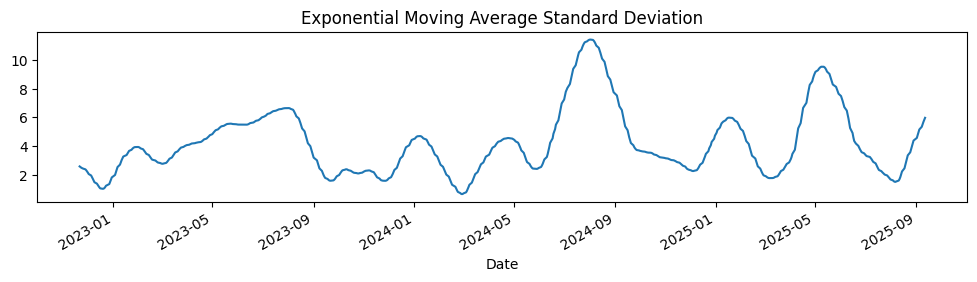

In [ ]:
#Other columns are DataFrames apparently
print(type(data["EMA_50"]))
print(type(data["Adj Close"]))
data["SMA_DIFF"] = data["SMA_50"] - data["Adj Close"].squeeze()
data["EMA_DIFF"] = data["EMA_50"] - data["Adj Close"].squeeze()
era_series = data["EMA_50"].squeeze()
data["EMA_STD"] = era_series.rolling(window=50).std()
data["EMA_STD"].plot(figsize=(12, 2.5), title = "Exponential Moving Average Standard Deviation")
plt.plot()

SMA_Close_DIFF Standard Deviation: 11.414472190041787
EMA_Close_DIFF Standard Deviation: 9.77892854804393


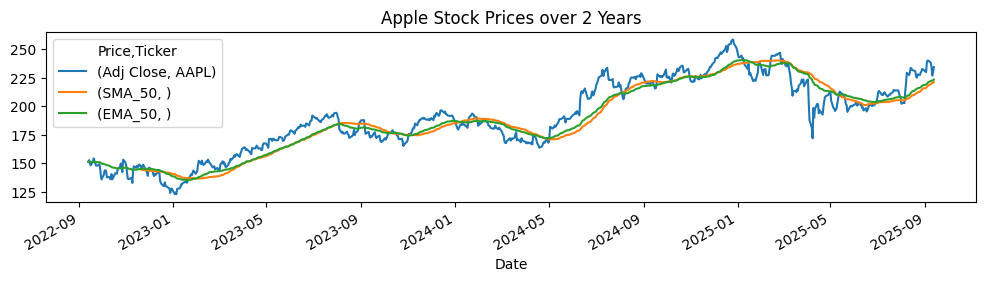

In [ ]:
#ERA is more reactive to volatility here, so I'll probably use that
#Also, Apple appears to be a volatile stock
print("SMA_Close_DIFF Standard Deviation: " + str(data["SMA_DIFF"].std()))
print("EMA_Close_DIFF Standard Deviation: " + str(data["EMA_DIFF"].std()))

data[['Adj Close', "SMA_50", "EMA_50"]].plot(figsize=(12, 2.5), title="Apple Stock Prices over 2 Years")
plt.show()

# Strategy

1. Create the exponential moving average trace for the Apple stock with a span of 50 days.
2. Use average true range to measure the volatility of the stock within a 20 day period.
3. Modify the k parameter to increase the buy/sell mark when the market is more volatile and decrease the buy/sell mark when the market is less volatile. This will be based on the the standard deviation of the exponential moving average and range between 0.75-1.25.
4. Decide on action (price > ema + k*atr --> buy) or trending downwards (price < ema + k*atr --> sell).

**Finding Exponential Moving Average**

N = period of days

alpha = 2/(N+1)

EMA_1 = Simple Moving Average over N days


EMA_today = (Close * alpha) + (EMA_yesterday * alpha)

**Finding Average True Range**

TR_i = max(high_i - low_i, |high_i-close_(i_1)|, |low_i-close(i_1)|)

ATR = EMA(TR_i) for all i's.

In [ ]:
def findATR(high, low, adj_close, window):
  tr = pd.concat([
      high-low,
      (high-adj_close.shift()).abs(),
      (low-adj_close.shift()).abs(),
  ], axis=1).max(axis=1)
  atr = tr.ewm(span=window, adjust=False).mean()
  return atr

In [ ]:
data["ATR_14"] = findATR(data["High"], data["Low"], data["Adj Close"], 14)
data["ATR_14"].head()

,ATR_14
Date,
2022-09-13,7.169998
2022-09-14,6.967422
2022-09-15,6.553100
2022-09-16,6.076688
2022-09-19,6.093379


In [ ]:
#For now I'll set k = 1.00, since that's a normal value for daily trading
k = 1.00

# Algorithm Implementation

In [ ]:
money = 1000
ret = []
hist = []
print(data.index[0])
print(data.index[-1])

in_stock = False
shares = 0
trades = 0

std_min = data["EMA_STD"].min()
std_max = data["EMA_STD"].max()

for i in range(50, len(data.index)-1):
  ERA = data["EMA_50"].iloc[i]
  ATR = data["ATR_14"].iloc[i]
  p_t = data["Adj Close"].squeeze().iloc[i]

  std = data["EMA_STD"].iloc[i]
  k = 0.75 + ((std - std_min) / (std_max - std_min) / 2) #dynamic k

  prev_value = money + shares * p_t

  if (not in_stock) and p_t > ERA + k*ATR:
    shares = money / p_t
    money = 0
    in_stock = True
  elif in_stock and p_t < ERA - k*ATR:
    money = shares * p_t
    shares = 0
    in_stock = False
    trades += 1

  total_value = money + shares * p_t
  hist.append(total_value)
  ret.append((total_value/prev_value) - 1)

print(f"Money: ${hist[-1]}")
print(f"Trades: {trades}")

2022-09-13 00:00:00
2025-09-12 00:00:00
Money: $1406.6903593345685
Trades: 8


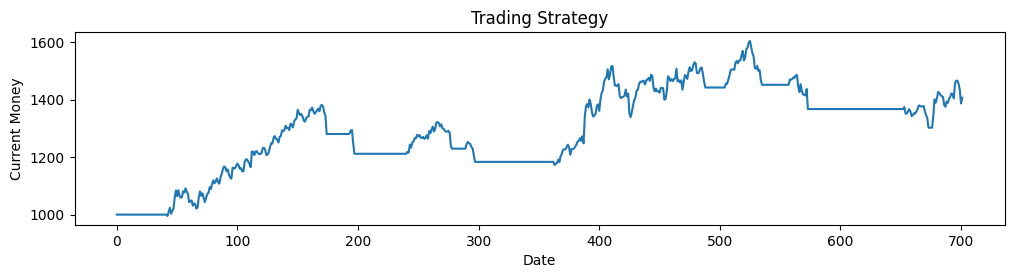

In [ ]:
plt.figure(figsize=(12, 2.5))
plt.plot(hist)
plt.xlabel("Date")
plt.ylabel("Current Money")
plt.title("Trading Strategy")

plt.show()

# Sharpe Ratio

In [ ]:
import numpy as np

hist = np.array(hist)

returns = np.diff(hist) / hist[:-1]

rf_daily = 0

excess_returns = returns - rf_daily

sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)

print("Sharpe Ratio:", sharpe_ratio)

Sharpe Ratio: 0.052075253396531615
